# Capstone ML/ AI

## Overview

Welcome to my Capstone project! In this project, I have thoroughly cleaned, processed, analyzed, and modeled EEG data to develop a reliable predictive model for diagnosing dementia. By leveraging advanced machine learning techniques, I aim to harness the power of EEG data to accurately identify individuals at risk of dementia. Join me on this exciting journey as we explore the potential of EEG analysis in revolutionizing dementia diagnosis.

## Import Libraries

In [27]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

# Ignore all warnings
warnings.filterwarnings("ignore")

import os
import glob

import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages')
import mne

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from tabulate import tabulate
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

## Dataset

This dataset contains the EEG recordings in resting state from 88 subjects in total.  

1. Participants: 36 of them were diagnosed with Alzheimer's disease (AD group), 23 were diagnosed with Frontotemporal Dementia (FTD group) and 29 were healthy subjects (CN group). Along with EEG data, cognitive state was evaluated by the international Mini-Mental State Examination (MMSE). 

2. EEG Recordings: Recordings were aquired with 19 scalp electrodes (Fp1, Fp2, F7, F3, Fz, F4, F8, T3, C3, Cz, C4, T4, T5, P3, Pz, P4, T6, O1, and O2)

3. Preprocessing: First, a Butterworth band-pass filter 0.5-45 Hz was applied. Then, the Independent Component Analysis (ICA) method was performed, transforming the 19 EEG signals to 19 ICA components. 


### Data Extraction

Once the derivates data have been downloaded from openneuro.org (link in README), run this cell to collect all required data from the source and move them into 1 folder.

In [ ]:
### Run 1 time: copy and add files from all folders in a directory to a single folder

import os
import shutil

# specify the path of the source directory
source_dir = '/Users/apekshasridhar/Downloads/Capstone-2/derivatives'

# specify the path of the destination directory
destination_dir = '/Users/apekshasridhar/Downloads/Capstone-2/all_subjs'

# loop through each subdirectory of the source directory
for root, dirs, files in os.walk(source_dir):
    # loop through each file in the current subdirectory
    for filename in files:
        # create the full path of the source file
        source_file = os.path.join(root, filename)
        # create the full path of the destination file
        destination_file = os.path.join(destination_dir, filename)
        # transfer the file to the destination directory
        shutil.copy(source_file, destination_file)


### Data Cleaning

Calculating measures of peak frequency, mean frequency, and global power from EEG data is essential for extracting meaningful information and enhancing predictive analysis using machine learning models. These measures provide valuable insights into the underlying neural activity and can significantly contribute to the accuracy and interpretability of EEG-based predictive models.

1. Peak frequency: This measure characterizes the dominant frequencies present in EEG signals. It captures important spectral information related to brain oscillations and can reveal patterns associated with different cognitive states or neurological conditions. 

2. Mean Frequency: It provides information about the overall distribution of frequencies present in the brain activity. By analyzing the mean frequency, we can gain insights into the average frequency bands and their contributions to cognitive processes. 

3. Global Power: Total power can be used as a measure of the overall brain activity level or arousal state. Higher total power values indicate greater overall electrical activity in the brain, while lower values may indicate reduced activity or a more quiescent state.



Creating three different dataframes for the three measures, i.e., peak frequency, mean frequency, and global power, allows for a more comprehensive analysis of the EEG data. Each measure captures distinct aspects of the brain activity and provides unique insights into cognitive processes and neurological conditions. By separating the measures into different dataframes, we can perform specific analyses on each measure individually and utilize ensemble techniques to aggregate the results and predict the classification task. 

In [2]:
## Preprocess

# Load EEG data and calculate the Peak Frequency, Mean Frequency, and Global Power for each EEG ICA channel.

directory = '/Users/psachdeva/Downloads/Capstone/all_subj'
file_pattern = '*.set'

mne.set_log_level("WARNING")  # Set the log level to suppress verbose messages

def process_file(file_path):
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    subj_id = os.path.basename(file_path).split('_')[0]
    ch_names = raw.ch_names
    # Get indices of EEG channels
    eeg_inds = mne.pick_types(raw.info, meg=False, eeg=True)
    # Perform Fourier transformation and obtain power spectral density values
    psds, freqs = mne.time_frequency.psd_array_multitaper(raw.get_data()[eeg_inds], sfreq=raw.info['sfreq'], fmax=50)

    # Create a list to store the calculated scores for each EEG channel
    channel_scores_peak = []
    channel_scores_mean = []
    channel_scores_gp = []

    # Iterate over each EEG channel
    for i, ch_idx in enumerate(eeg_inds):
        channel_name = ch_names[ch_idx]
        channel_psds = psds[i]

        # Calculate the peak frequency for the channel
        peak_freq = freqs[np.argmax(channel_psds)]
        # Calculate the mean frequency for the channel
        mean_freq = np.sum(channel_psds * freqs) / np.sum(channel_psds)
        # Calculate the Global Power for the channel (sum of power across all frequencies)
        gp = np.sum(channel_psds)

        # Append the calculated scores for the channel to the respective lists
        channel_scores_peak.append([subj_id, 'Peak Frequency', channel_name, peak_freq])
        channel_scores_mean.append([subj_id, 'Mean Frequency', channel_name, mean_freq])
        channel_scores_gp.append([subj_id, 'Global Power', channel_name, gp])

    # Create DataFrames from the lists of scores for the subject
    df_subject_peak = pd.DataFrame(channel_scores_peak, columns=['subj_id', 'Type', 'Channel', 'Value'])
    df_subject_mean = pd.DataFrame(channel_scores_mean, columns=['subj_id', 'Type', 'Channel', 'Value'])
    df_subject_gp = pd.DataFrame(channel_scores_gp, columns=['subj_id', 'Type', 'Channel', 'Value'])

    return df_subject_peak, df_subject_mean, df_subject_gp

df_list_peak = []
df_list_mean = []
df_list_gp = []
for file_path in glob.glob(os.path.join(directory, file_pattern)):
    df_peak, df_mean, df_gp = process_file(file_path)
    df_list_peak.append(df_peak)
    df_list_mean.append(df_mean)
    df_list_gp.append(df_gp)

df_peak = pd.concat(df_list_peak, axis=0, ignore_index=True)
df_mean = pd.concat(df_list_mean, axis=0, ignore_index=True)
df_gp = pd.concat(df_list_gp, axis=0, ignore_index=True)

# Reshape the DataFrames to have channels as columns
df_peak = df_peak.pivot(index=['subj_id', 'Type'], columns='Channel', values='Value').reset_index()
df_mean = df_mean.pivot(index=['subj_id', 'Type'], columns='Channel', values='Value').reset_index()
df_gp = df_gp.pivot(index=['subj_id', 'Type'], columns='Channel', values='Value').reset_index()

print("Peak Frequency DataFrame shape:", df_peak.shape)
print("Mean Frequency DataFrame shape:", df_mean.shape)
print("Global Power DataFrame shape:", df_gp.shape)


Peak Frequency DataFrame shape: (88, 21)
Mean Frequency DataFrame shape: (88, 21)
Global Power DataFrame shape: (88, 21)


In [13]:
df_peak.head()

Channel,subj_id,Type,C3,C4,Cz,F3,F4,F7,F8,Fp1,...,Fz,O1,O2,P3,P4,Pz,T3,T4,T5,T6
0,sub-001,Peak Frequency,0.406802,0.406802,0.406802,0.406802,0.406802,0.406802,0.406802,0.360120,...,0.406802,0.406802,0.351784,0.406802,0.351784,0.406802,0.406802,0.406802,0.351784,0.406802
1,sub-002,Peak Frequency,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,...,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263
2,sub-003,Peak Frequency,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,...,0.336491,0.378961,0.378961,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491
3,sub-004,Peak Frequency,0.413539,0.495680,0.413539,0.495680,0.495680,0.495680,0.495680,0.413539,...,0.495680,0.376717,0.366804,0.379550,0.379550,0.495680,0.373885,0.495680,0.373885,0.379550
4,sub-005,Peak Frequency,0.419102,0.419102,0.419102,0.419102,0.395473,0.419102,0.419102,0.400448,...,0.419102,0.323343,0.419102,0.419102,0.419102,0.419102,0.320856,0.419102,0.419102,0.419102


Add demographics information to all Dataframes as it contains the diagnostic information.

In [4]:
dx = pd.read_csv('/Users/psachdeva/Downloads/Capstone/participants.tsv', sep='\t')
df_peak_full = pd.merge(df_peak, dx, left_on='subj_id', right_on='participant_id', how = 'left')
df_peak_full.drop('participant_id', axis=1, inplace=True)
df_peak_full = df_peak_full.set_index('subj_id')

df_mean_full = pd.merge(df_mean, dx, left_on='subj_id', right_on='participant_id', how = 'left')
df_mean_full.drop('participant_id', axis=1, inplace=True)
df_mean_full = df_mean_full.set_index('subj_id')
df_mean_full.head()

df_gp_full = pd.merge(df_gp, dx, left_on='subj_id', right_on='participant_id', how = 'left')
df_gp_full.drop('participant_id', axis=1, inplace=True)
df_gp_full = df_gp_full.set_index('subj_id')

df_peak_full.head()

,Type,C3,C4,Cz,F3,F4,F7,F8,Fp1,Fp2,...,P4,Pz,T3,T4,T5,T6,Gender,Age,Group,MMSE
subj_id,,,,,,,,,,,,,,,,,,,,,
sub-001,Peak Frequency,0.406802,0.406802,0.406802,0.406802,0.406802,0.406802,0.406802,0.360120,0.406802,...,0.351784,0.406802,0.406802,0.406802,0.351784,0.406802,F,57,A,16
sub-002,Peak Frequency,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,...,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,F,78,A,22
sub-003,Peak Frequency,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,...,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,M,70,A,14
sub-004,Peak Frequency,0.413539,0.495680,0.413539,0.495680,0.495680,0.495680,0.495680,0.413539,0.495680,...,0.379550,0.495680,0.373885,0.495680,0.373885,0.379550,F,67,A,20
sub-005,Peak Frequency,0.419102,0.419102,0.419102,0.419102,0.395473,0.419102,0.419102,0.400448,0.419102,...,0.419102,0.419102,0.320856,0.419102,0.419102,0.419102,M,70,A,22


Drop the Gender column.

In [5]:
df_peak_full.drop(columns = 'Gender', inplace = True, axis = 1)
df_mean_full.drop(columns = 'Gender', inplace = True, axis = 1)
df_gp_full.drop(columns = 'Gender', inplace = True, axis = 1)


df_peak_full.columns

Index(['Type', 'C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'Fz',
       'O1', 'O2', 'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'Age', 'Group',
       'MMSE'],
      dtype='object')

### Feature Engineering

Examining data to make sure there are no missing values.

In [6]:
df_peak_full.isnull().sum()

Type     0
C3       0
C4       0
Cz       0
F3       0
F4       0
F7       0
F8       0
Fp1      0
Fp2      0
Fz       0
O1       0
O2       0
P3       0
P4       0
Pz       0
T3       0
T4       0
T5       0
T6       0
Age      0
Group    0
MMSE     0
dtype: int64

In [7]:
df_mean_full.isnull().sum()

Type     0
C3       0
C4       0
Cz       0
F3       0
F4       0
F7       0
F8       0
Fp1      0
Fp2      0
Fz       0
O1       0
O2       0
P3       0
P4       0
Pz       0
T3       0
T4       0
T5       0
T6       0
Age      0
Group    0
MMSE     0
dtype: int64

In [8]:
df_gp_full.isnull().sum()

Type     0
C3       0
C4       0
Cz       0
F3       0
F4       0
F7       0
F8       0
Fp1      0
Fp2      0
Fz       0
O1       0
O2       0
P3       0
P4       0
Pz       0
T3       0
T4       0
T5       0
T6       0
Age      0
Group    0
MMSE     0
dtype: int64

### Examine balance of classes in target variable.

Convert target variable to numeric values where 0 represents healthy individuals and 1 represents individuals with dementia.

In [9]:
# Now convert y to numerical

df_peak_full['dx_num'] = df_peak_full['Group'].map({
    'C': 0,
    'F': 1, 
    'A': 1
})

df_mean_full['dx_num'] = df_mean_full['Group'].map({
    'C': 0,
    'F': 1, 
    'A': 1
})

df_gp_full['dx_num'] = df_gp_full['Group'].map({
    'C': 0,
    'F': 1, 
    'A': 1
})

In [10]:
df_peak_full.dx_num.value_counts()

1    59
0    29
Name: dx_num, dtype: int64

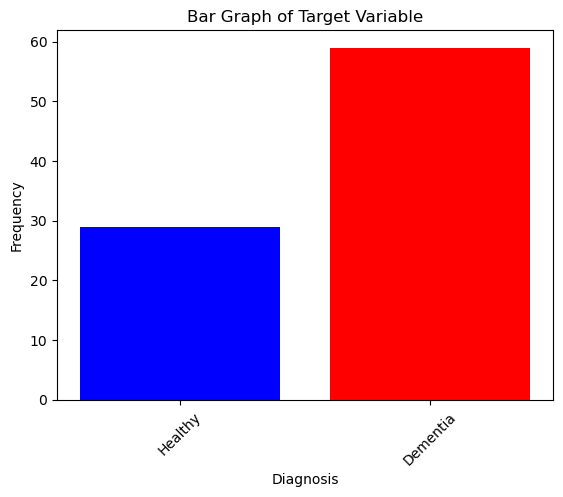

In [11]:
import matplotlib.pyplot as plt

# Create a bar plot of y
plt.bar(df_peak_full.dx_num.unique(), df_peak_full.dx_num.value_counts(), color=['red', 'blue'])


label_names = ['Dementia', 'Healthy']
plt.xticks(df_peak_full.dx_num.unique(), label_names, rotation = 45)

# Add labels and title to the plot
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Bar Graph of Target Variable')

# Show the plot
plt.show()

The bar graph clearly illustrates that the number of subjects diagnosed with dementia is higher than the number of healthy controls. This observation indicates an imbalance in the dataset, with a larger representation of the clinical group.

To address this class imbalance, one approach is to oversample the minority class (healthy controls) to create a more balanced training set. However, in the context of diagnosis, having a larger number of samples in the clinical group can be beneficial as it allows the model to learn and capture the patterns and characteristics specific to the disease.

In this project, we will examine if oversampling the healthy controls improves the performance of the predictive models. Nonetheless, we will also consider that having a higher number of samples in the clinical group is acceptable and may contribute to better diagnostic accuracy.

In [12]:
df_peak_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, sub-001 to sub-088
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Type    88 non-null     object 
 1   C3      88 non-null     float64
 2   C4      88 non-null     float64
 3   Cz      88 non-null     float64
 4   F3      88 non-null     float64
 5   F4      88 non-null     float64
 6   F7      88 non-null     float64
 7   F8      88 non-null     float64
 8   Fp1     88 non-null     float64
 9   Fp2     88 non-null     float64
 10  Fz      88 non-null     float64
 11  O1      88 non-null     float64
 12  O2      88 non-null     float64
 13  P3      88 non-null     float64
 14  P4      88 non-null     float64
 15  Pz      88 non-null     float64
 16  T3      88 non-null     float64
 17  T4      88 non-null     float64
 18  T5      88 non-null     float64
 19  T6      88 non-null     float64
 20  Age     88 non-null     int64  
 21  Group   88 non-null     object 
 22

### Train Test Split

This separates the input features (X) and the target variable (y) into training and testing sets using the train_test_split function from scikit-learn. The split is stratified, preserving the class distribution of the target variable, and the test set size is set to 20% of the data. The resulting sets (X_train, X_test, y_train, y_test) can be used for training and evaluating machine learning models.

In [13]:

X_peak = df_peak_full.reset_index().drop(columns = ['dx_num', 'Group', 'subj_id', 'Age', 'Type'], axis=1)
y_peak = df_peak_full['dx_num']

X_mean = df_mean_full.reset_index().drop(columns = ['dx_num', 'Group', 'subj_id', 'Age', 'Type', 'MMSE'], axis=1)
y_mean = df_mean_full['dx_num']

X_gp = df_gp_full.reset_index().drop(columns = ['dx_num', 'Group', 'subj_id', 'Age', 'Type', 'MMSE'], axis=1)
y_gp = df_gp_full['dx_num']


In [14]:

X_train_peak, X_test_peak, y_train_peak, y_test_peak = train_test_split(X_peak, y_peak, test_size = 0.2, random_state = 32, stratify = y_peak)
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean, y_mean, test_size = 0.2, random_state = 32, stratify = y_mean)
X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(X_gp, y_gp, test_size = 0.2, random_state = 32, stratify = y_gp)


### Oversampling for Balanced Classes using SMOTE.

Now I use SMOTE to ensure a more balanced representation of the classes in the training data, which can lead to improved performance of machine learning models, especially when dealing with imbalanced datasets.

In [15]:

# initialize SMOTE
sm = SMOTE(random_state=42)
X_train_peak_resampled, y_train_peak_resampled = sm.fit_resample(X_train_peak, y_train_peak)
X_train_mean_resampled, y_train_mean_resampled = sm.fit_resample(X_train_mean, y_train_mean)
X_train_gp_resampled, y_train_gp_resampled = sm.fit_resample(X_train_gp, y_train_gp)

print(X_train_peak_resampled.shape, X_train_peak.shape)


(94, 20) (70, 20)


In [16]:
X_train_peak_resampled.columns

Index(['C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'Fz', 'O1',
       'O2', 'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'MMSE'],
      dtype='object')

In [17]:
y_train_peak_resampled.value_counts()

1    47
0    47
Name: dx_num, dtype: int64

## Research Question

To what extent can the comprehensive analysis of peak frequency, mean frequency, and Global Power extracted from EEG data provide reliable and discriminative biomarkers for the precise and early detection of dementia (specifically Alzheimers and Frontotemporal Dementia)?


## Principal Component Analysis (PCA)


PCA is commonly used to reduce the number of EEG ICA components in order to address the problem of high-dimensional data. By applying PCA, the goal is to capture the most important features or patterns in the EEG data while reducing the dimensionality. 

#### Scree plot to choose best number of components for PCA.

This code performs PCA on the scaled training data and generates a scree plot. The scree plot allows visual assessment of the explained variance ratio by each principal component, helping to determine the optimal number of components to retain for dimensionality reduction.

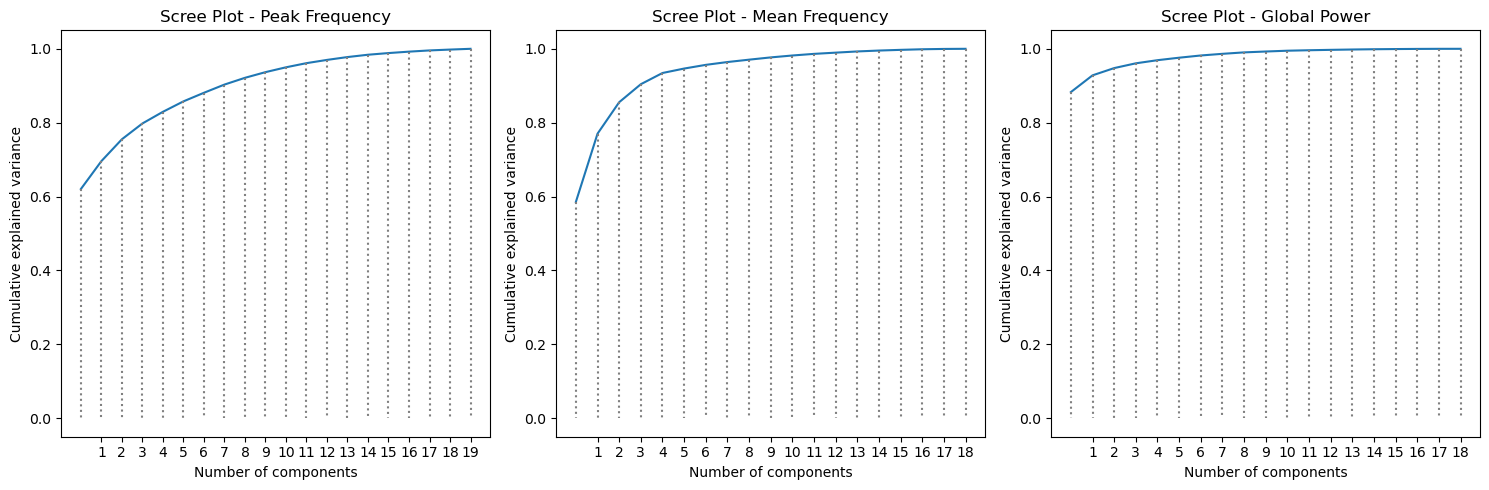

In [18]:

X_train_peak_resampled = X_train_peak
X_train_mean_resampled = X_train_mean
X_train_gp_resampled = X_train_gp

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the training data for each dataset
X_train_peak_scaled = scaler.fit_transform(X_train_peak_resampled)
X_train_mean_scaled = scaler.fit_transform(X_train_mean_resampled)
X_train_gp_scaled = scaler.fit_transform(X_train_gp_resampled)

# Create a PCA object for each dataset
pca_peak = PCA()
pca_mean = PCA()
pca_gp = PCA()

# Fit the PCA models to the scaled data for each dataset
pca_peak.fit(X_train_peak_scaled)
pca_mean.fit(X_train_mean_scaled)
pca_gp.fit(X_train_gp_scaled)

# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the scree plots for each dataset
axs[0].plot(np.cumsum(pca_peak.explained_variance_ratio_))
axs[0].set_xlabel('Number of components')
axs[0].set_ylabel('Cumulative explained variance')
axs[0].set_title('Scree Plot - Peak Frequency')
axs[0].set_xticks(np.arange(1, len(pca_peak.explained_variance_ratio_) + 1, 1))

axs[1].plot(np.cumsum(pca_mean.explained_variance_ratio_))
axs[1].set_xlabel('Number of components')
axs[1].set_ylabel('Cumulative explained variance')
axs[1].set_title('Scree Plot - Mean Frequency')
axs[1].set_xticks(np.arange(1, len(pca_mean.explained_variance_ratio_) + 1, 1))

axs[2].plot(np.cumsum(pca_gp.explained_variance_ratio_))
axs[2].set_xlabel('Number of components')
axs[2].set_ylabel('Cumulative explained variance')
axs[2].set_title('Scree Plot - Global Power')
axs[2].set_xticks(np.arange(1, len(pca_gp.explained_variance_ratio_) + 1, 1))

# Draw dotted lines from each point to the x-axis
for ax in axs:
    for line in ax.lines:
        x = line.get_xdata()
        y = line.get_ydata()
        for xi, yi in zip(x, y):
            ax.plot([xi, xi], [yi, 0], color='gray', linestyle='dotted')

# Adjust spacing between subplots
plt.tight_layout()


# Display the plot
plt.show()

Using 90% as the threshold for amount of variance explained: 
1. Peak frequency: 9 components
2. Mean frequency: 4 components
3. Global Power: 2 components

#### Visualizing PCA just for Global Power data

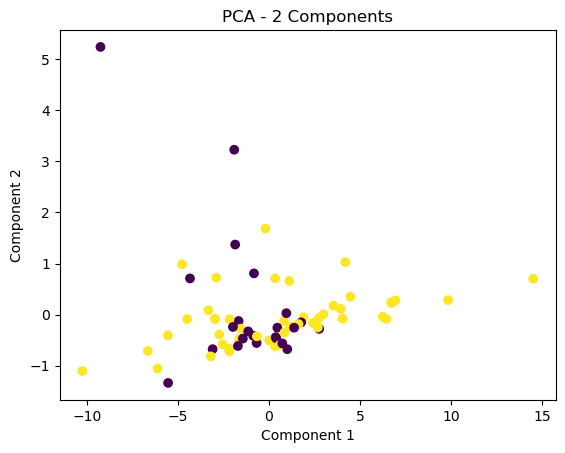

In [19]:

# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=2)
X_train_gp_reduced = pca.fit_transform(X_train_gp_scaled)

# Plot the reduced data
plt.scatter(X_train_gp_reduced[:, 0], X_train_gp_reduced[:, 1], c=y_train_gp)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA - 2 Components')
plt.show()


Although not very clear from the graph, the scree plot indicates 2 components to be enough to explain more than 90% variance.

### Running PCA for all 3 datasets

In [20]:
# Apply PCA to reduce the dimensionality of the data
scaler = StandardScaler()

# Scale the training data for each dataset
X_train_peak_scaled = scaler.fit_transform(X_train_peak_resampled)
X_train_mean_scaled = scaler.fit_transform(X_train_mean_resampled)
X_train_gp_scaled = scaler.fit_transform(X_train_gp_resampled)

# Train data

pca = PCA(n_components=9)
X_train_peak_reduced = pca.fit_transform(X_train_peak_scaled)

pca = PCA(n_components=5)
X_train_mean_reduced = pca.fit_transform(X_train_mean_scaled)

pca = PCA(n_components=2)
X_train_gp_reduced = pca.fit_transform(X_train_gp_scaled)

# Test data

# Scale the training data for each dataset
X_test_peak_scaled = scaler.fit_transform(X_test_peak)
X_test_mean_scaled = scaler.fit_transform(X_test_mean)
X_test_gp_scaled = scaler.fit_transform(X_test_gp)

pca = PCA(n_components=9)
X_test_peak_reduced = pca.fit_transform(X_test_peak_scaled)

pca = PCA(n_components=5)
X_test_mean_reduced = pca.fit_transform(X_test_mean_scaled)

pca = PCA(n_components=2)
X_test_gp_reduced = pca.fit_transform(X_test_gp_scaled)

In [21]:
# Converting components to DF

X_train_peak_reduced = pd.DataFrame(data=X_train_peak_reduced, columns=['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7', 'Component 8', 'Component 9'])
X_train_mean_reduced = pd.DataFrame(data=X_train_mean_reduced, columns=['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5'])
X_train_gp_reduced = pd.DataFrame(data=X_train_gp_reduced, columns=['Component 1', 'Component 2'])


## Performance Metric

I selected accuracy as the primary performance metric for diagnosing dementia in EEG data because it provides a comprehensive measure of the model's overall correctness in predicting the disease status. Accuracy considers both true positives and true negatives and offers a straightforward evaluation of the model's effectiveness. However, recognizing the importance of other evaluation aspects, I will also investigate precision and recall for each model. Precision will help assess the model's ability to minimize false positives, while recall will provide insights into its capability to capture true positives. By examining multiple metrics, I aim to gain a more comprehensive understanding of each model's diagnostic performance.

# Classical ML Classification Models

### Decision Tree


Initially, I explored the data after balancing the classes using SMOTE (Synthetic Minority Over-sampling Technique). However, I observed a significant improvement in accuracy when using the original unbalanced data. As a result, I decided to proceed with the original data for training my models.

In [23]:

# Define the parameter grid for each decision tree model
param_grid_dtc = {
    'max_depth': [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80],
    'min_samples_split': [5, 10, 15, 20, 25, 30, 35],
    'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35]
}

model_peak_dtc = DecisionTreeClassifier()
model_mean_dtc = DecisionTreeClassifier()
model_gp_dtc = DecisionTreeClassifier()

# Create GridSearchCV objects for each decision tree model
grid_search_peak = GridSearchCV(estimator=model_peak_dtc, param_grid=param_grid_dtc, scoring='accuracy', cv=5)
grid_search_mean = GridSearchCV(estimator=model_mean_dtc, param_grid=param_grid_dtc, scoring='accuracy', cv=5)
grid_search_gp = GridSearchCV(estimator=model_gp_dtc, param_grid=param_grid_dtc, scoring='accuracy', cv=5)

# Fit the GridSearchCV objects to the respective datasets
grid_search_peak.fit(X_train_peak_reduced, y_train_peak)
grid_search_mean.fit(X_train_mean_reduced, y_train_mean)
grid_search_gp.fit(X_train_gp_reduced, y_train_gp)

# Get the best estimators from the grid search
best_model_peak = grid_search_peak.best_estimator_
best_model_mean = grid_search_mean.best_estimator_
best_model_gp = grid_search_gp.best_estimator_

# Make predictions for each subject's test data using the best models
pred_peak_dtc = best_model_peak.predict(X_test_peak_reduced)
pred_mean_dtc = best_model_mean.predict(X_test_mean_reduced)
pred_gp_dtc = best_model_gp.predict(X_test_gp_reduced)

# Majority vote approach
predictions_dtc = []
for i in range(len(X_test_peak_reduced)):
    votes = [pred_peak_dtc[i], pred_mean_dtc[i], pred_gp_dtc[i]]
    majority_vote = max(set(votes), key=votes.count)
    predictions_dtc.append(majority_vote)

# Evaluate the accuracy of the ensemble models
accuracy_majority_vote = np.mean(predictions_dtc == y_test_peak)

print("Accuracy (Majority Vote) - Decision Tree:", accuracy_majority_vote)

precision_dtc = precision_score(y_test_peak, predictions_dtc)
recall_dtc = recall_score(y_test_peak, predictions_dtc)               

# Print the precision and recall score
print("Precision Score - Decision Tree:", precision_dtc)
print("Recall Score - Decision Tree:", recall_dtc)

Accuracy (Majority Vote) - Decision Tree: 0.8333333333333334
Precision Score - Decision Tree: 0.8461538461538461
Recall Score - Decision Tree: 0.9166666666666666


### Logistic Regression

In [24]:
# Define the parameter grid for Logistic Regression model
param_grid_lgr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100]
}

model_peak_lgr = LogisticRegression()
model_mean_lgr = LogisticRegression()
model_gp_lgr = LogisticRegression()

# Create GridSearchCV objects for each decision tree model
grid_lgr_peak = GridSearchCV(estimator=model_peak_lgr, param_grid=param_grid_lgr, scoring='accuracy', cv=5)
grid_lgr_mean = GridSearchCV(estimator=model_mean_lgr, param_grid=param_grid_lgr, scoring='accuracy', cv=5)
grid_lgr_gp = GridSearchCV(estimator=model_gp_lgr, param_grid=param_grid_lgr, scoring='accuracy', cv=5)

# Fit the GridSearchCV objects to the respective datasets
grid_lgr_peak.fit(X_train_peak_reduced, y_train_peak)
grid_lgr_mean.fit(X_train_mean_reduced, y_train_mean)
grid_lgr_gp.fit(X_train_gp_reduced, y_train_gp)

# Get the best estimators from the grid search
best_lgr_peak = grid_lgr_peak.best_estimator_
best_lgr_mean = grid_lgr_mean.best_estimator_
best_lgr_gp = grid_lgr_gp.best_estimator_

# Make predictions for each subject's test data using the best models
pred_peak_lgr = best_lgr_peak.predict(X_test_peak_reduced)
pred_mean_lgr = best_lgr_mean.predict(X_test_mean_reduced)
pred_gp_lgr = best_lgr_gp.predict(X_test_gp_reduced)

# Majority vote approach
predictions_lgr = []
for i in range(len(X_test_peak_reduced)):
    votes = [pred_peak_lgr[i], pred_mean_lgr[i], pred_gp_lgr[i]]
    majority_vote = max(set(votes), key=votes.count)
    predictions_lgr.append(majority_vote)

# Evaluate the accuracy of the ensemble models
accuracy_majority_vote_logistic = np.mean(predictions_lgr == y_test_peak)

print("Accuracy (Majority Vote - Logistic Regression):", accuracy_majority_vote_logistic)

precision_lgr = precision_score(y_test_peak, predictions_lgr)
recall_lgr = recall_score(y_test_peak, predictions_lgr)

print("Precision Score - Logistic Regression:", precision_lgr)
print("Recall Score - Logistic Regression:", recall_lgr)

Accuracy (Majority Vote - Logistic Regression): 0.5555555555555556
Precision Score - Logistic Regression: 0.625
Recall Score - Logistic Regression: 0.8333333333333334


### K-Nearest Neighbors

In [28]:
# Define the hyperparameter grid to search over
param_grid_knn = {'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'weights': ['distance', 'uniform']}

model_peak_knn = KNeighborsClassifier()
model_mean_knn = KNeighborsClassifier()
model_gp_knn = KNeighborsClassifier()

# Create GridSearchCV objects for each KNeighborsClassifier model
grid_knn_peak = GridSearchCV(estimator=model_peak_knn, param_grid=param_grid_knn, scoring='accuracy', cv=5)
grid_knn_mean = GridSearchCV(estimator=model_mean_knn, param_grid=param_grid_knn, scoring='accuracy', cv=5)
grid_knn_gp = GridSearchCV(estimator=model_gp_knn, param_grid=param_grid_knn, scoring='accuracy', cv=5)

# Fit the GridSearchCV objects to the respective datasets
grid_knn_peak.fit(X_train_peak_reduced, y_train_peak)
grid_knn_mean.fit(X_train_mean_reduced, y_train_mean)
grid_knn_gp.fit(X_train_gp_reduced, y_train_gp)

# Get the best estimators from the grid search
best_knn_peak = grid_knn_peak.best_estimator_
best_knn_mean = grid_knn_mean.best_estimator_
best_knn_gp = grid_knn_gp.best_estimator_

# Make predictions for each subject's test data using the best models
pred_peak_knn = best_knn_peak.predict(X_test_peak_reduced)
pred_mean_knn = best_knn_mean.predict(X_test_mean_reduced)
pred_gp_knn = best_knn_gp.predict(X_test_gp_reduced)

# Majority vote approach
predictions_knn = []
for i in range(len(X_test_peak_reduced)):
    votes = [pred_peak_knn[i], pred_mean_knn[i], pred_gp_knn[i]]
    majority_vote = max(set(votes), key=votes.count)
    predictions_knn.append(majority_vote)

# Evaluate the accuracy of the ensemble models
accuracy_majority_vote_knn = np.mean(predictions_knn == y_test_peak)

print("Accuracy (Majority Vote - KNN):", accuracy_majority_vote_knn)

precision_knn = precision_score(y_test_peak, predictions_knn)
recall_knn = recall_score(y_test_peak, predictions_knn)

print("Precision Score - K-Nearest Neighbors:", precision_knn)
print("Recall Score - K-Nearest Neighbors:", recall_knn)

Accuracy (Majority Vote - KNN): 0.7222222222222222
Precision Score - K-Nearest Neighbors: 0.7692307692307693
Recall Score - K-Nearest Neighbors: 0.8333333333333334


### SVM

In [29]:
# Define the parameter grid for GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

model_peak_svm = SVC()
model_mean_svm = SVC()
model_gp_svm = SVC()

# Create GridSearchCV objects for each SVC model
grid_svm_peak = GridSearchCV(estimator=model_peak_svm, param_grid=param_grid_svm, scoring='accuracy', cv=5)
grid_svm_mean = GridSearchCV(estimator=model_mean_svm, param_grid=param_grid_svm, scoring='accuracy', cv=5)
grid_svm_gp = GridSearchCV(estimator=model_gp_svm, param_grid=param_grid_svm, scoring='accuracy', cv=5)

# Fit the GridSearchCV objects to the respective datasets
grid_svm_peak.fit(X_train_peak_reduced, y_train_peak)
grid_svm_mean.fit(X_train_mean_reduced, y_train_mean)
grid_svm_gp.fit(X_train_gp_reduced, y_train_gp)

# Get the best estimators from the grid search
best_svm_peak = grid_svm_peak.best_estimator_
best_svm_mean = grid_svm_mean.best_estimator_
best_svm_gp = grid_svm_gp.best_estimator_

# Make predictions for each subject's test data using the best models
pred_peak_svm = best_svm_peak.predict(X_test_peak_reduced)
pred_mean_svm = best_svm_mean.predict(X_test_mean_reduced)
pred_gp_svm = best_svm_gp.predict(X_test_gp_reduced)

# Majority vote approach
predictions_svm = []
for i in range(len(X_test_peak_reduced)):
    votes = [pred_peak_svm[i], pred_mean_svm[i], pred_gp_svm[i]]
    majority_vote = max(set(votes), key=votes.count)
    predictions_svm.append(majority_vote)

# Evaluate the accuracy of the ensemble models
accuracy_majority_vote_svm = np.mean(predictions_svm == y_test_peak)

print("Accuracy (Majority Vote - SVM):", accuracy_majority_vote_svm)

precision_svm = precision_score(y_test_peak, predictions_svm)
recall_svm = recall_score(y_test_peak, predictions_svm)

print("Precision Score - Support Vector Machine:", precision_svm)
print("Recall Score - Support Vector Machine:", recall_svm)

Accuracy (Majority Vote - SVM): 0.5555555555555556
Precision Score - Support Vector Machine: 0.625
Recall Score - Support Vector Machine: 0.8333333333333334


### Confusion Matrix 

Confusion matrices are helpful in multiclass classification because they provide a comprehensive and detailed evaluation of the performance of a classifier across multiple classes. 

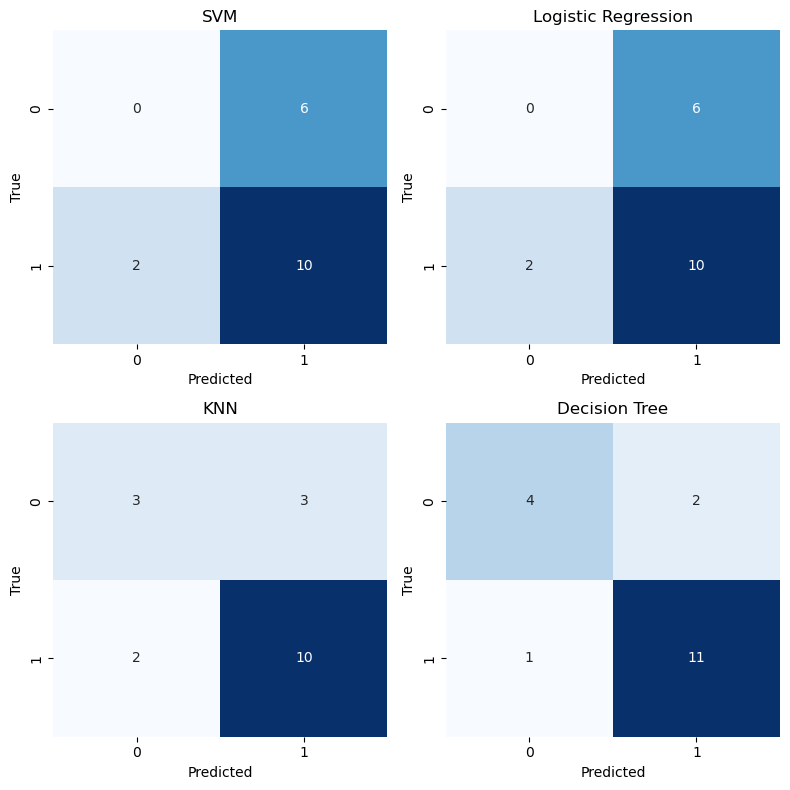

In [30]:

# Create a list of prediction results and corresponding labels
predictions = [predictions_svm, predictions_lgr, predictions_knn, predictions_dtc]
labels = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# Iterate over each model's predictions and plot the confusion matrix
for i, prediction in enumerate(predictions):
    row = i // 2
    col = i % 2
    ax = axes[row][col]
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test_peak, prediction)
    
    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(labels[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


The confusion matrices show that the Decision Tree Classifier was in fact the best performing model.

### Further investigating Decison Trees

Since the Decision Tree Classifier (DTC) performed the best among the models, I will now refit the model on the original data to investigate the importance of features. Specifically, I will compare the importance of features related to peak frequency, mean frequency, and Global Power. By analyzing the importance scores, I aim to identify significant features within each category and determine if there are any overlapping features that contribute to the diagnosis of dementia. This analysis will provide valuable insights into the discriminatory power of different EEG features and their relevance for dementia diagnosis.

#### Re-fitting the DTC model

In [31]:
grid_search_peak.fit(X_train_peak_scaled, y_train_peak)
grid_search_mean.fit(X_train_mean_scaled, y_train_mean)
grid_search_gp.fit(X_train_gp_scaled, y_train_gp)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [25, 30, 35, 40, 45, 50, 55, 60, 65, 70,
                                       75, 80],
                         'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35],
                         'min_samples_split': [5, 10, 15, 20, 25, 30, 35]},
             scoring='accuracy')

#### Plot the important features

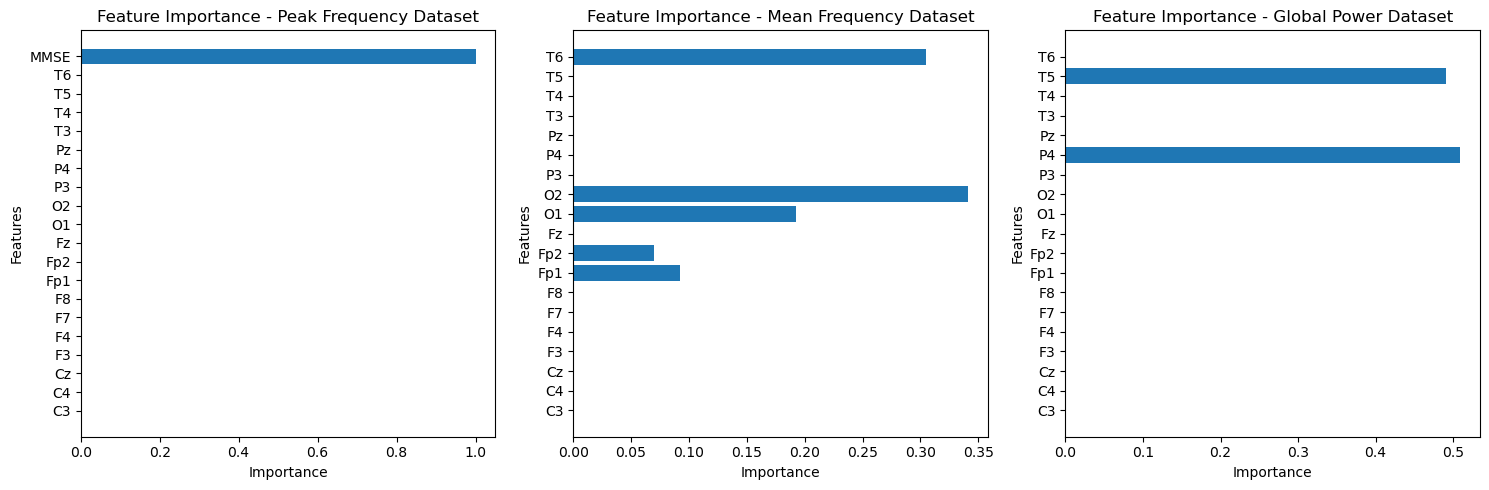

In [32]:

# Get feature importance for each DTC model
feature_importance_peak = grid_search_peak.best_estimator_.feature_importances_
feature_importance_mean = grid_search_mean.best_estimator_.feature_importances_
feature_importance_gp = grid_search_gp.best_estimator_.feature_importances_

# Get feature names
feature_names_peak = X_train_peak.columns
feature_names_mean = X_train_mean.columns
feature_names_gp = X_train_gp.columns

# Create subplots for each dataset
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot feature importance for Peak dataset
axes[0].barh(feature_names_peak, feature_importance_peak)
axes[0].set_title('Feature Importance - Peak Frequency Dataset')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Features')

# Plot feature importance for Mean dataset
axes[1].barh(feature_names_mean, feature_importance_mean)
axes[1].set_title('Feature Importance - Mean Frequency Dataset')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Features')

# Plot feature importance for Global Power dataset
axes[2].barh(feature_names_gp, feature_importance_gp)
axes[2].set_title('Feature Importance - Global Power Dataset')
axes[2].set_xlabel('Importance')
axes[2].set_ylabel('Features')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Upon examining the feature importance results, it is observed that there are no overlapping features between the different measures (peak frequency, mean frequency, and Global Power). This finding highlights the importance of analyzing the measures separately by fitting them on different models before aggregating the results. It suggests that each measure captures unique and distinct information regarding dementia diagnosis. 

### Random Forests

Since the decision tree model shows promising accuracy, using a random forest classifier may yield even better results. Random forests build an ensemble of decision trees, leveraging the diversity and combination of multiple trees to improve overall performance. By averaging the predictions of individual trees and reducing overfitting, random forests can handle complex datasets and provide robust and accurate predictions. 

In [33]:
# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [25, 50, 100],  # Number of trees in the random forest
    'max_depth': [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80],
    'min_samples_split': [5, 10, 15, 20, 25, 30, 35],
    'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35]
}

model_peak_rf = RandomForestClassifier()
model_mean_rf = RandomForestClassifier()
model_gp_rf = RandomForestClassifier()

# Create GridSearchCV objects for each Random Forest model
grid_rf_peak = GridSearchCV(estimator=model_peak_rf, param_grid=param_grid_rf, scoring='accuracy', cv=5)
grid_rf_mean = GridSearchCV(estimator=model_mean_rf, param_grid=param_grid_rf, scoring='accuracy', cv=5)
grid_rf_gp = GridSearchCV(estimator=model_gp_rf, param_grid=param_grid_rf, scoring='accuracy', cv=5)

# Fit the GridSearchCV objects to the respective datasets
grid_rf_peak.fit(X_train_peak_reduced, y_train_peak)
grid_rf_mean.fit(X_train_mean_reduced, y_train_mean)
grid_rf_gp.fit(X_train_gp_reduced, y_train_gp)

# Get the best estimators from the grid search
best_rf_peak = grid_rf_peak.best_estimator_
best_rf_mean = grid_rf_mean.best_estimator_
best_rf_gp = grid_rf_gp.best_estimator_

# Make predictions for each subject's test data using the best models
pred_peak_rf = best_rf_peak.predict(X_test_peak_reduced)
pred_mean_rf = best_rf_mean.predict(X_test_mean_reduced)
pred_gp_rf = best_rf_gp.predict(X_test_gp_reduced)

# Majority vote approach
predictions_rf = []
for i in range(len(X_test_peak_reduced)):
    votes = [pred_peak_rf[i], pred_mean_rf[i], pred_gp_rf[i]]
    majority_vote = max(set(votes), key=votes.count)
    predictions_rf.append(majority_vote)

# Evaluate the accuracy of the ensemble models
accuracy_majority_vote_rf = np.mean(predictions_rf == y_test_peak)

print("Accuracy (Majority Vote - Random Forest):", accuracy_majority_vote_rf)

precision_rf = precision_score(y_test_peak, predictions_rf)
recall_rf = recall_score(y_test_peak, predictions_rf)

print("Precision Score - Random Forest:", precision_rf)
print("Recall Score - Random Forest:", recall_rf)

Accuracy (Majority Vote - Random Forest): 0.5
Precision Score - Random Forest: 0.6153846153846154
Recall Score - Random Forest: 0.6666666666666666


####  Confusion Matrix for Random Forests

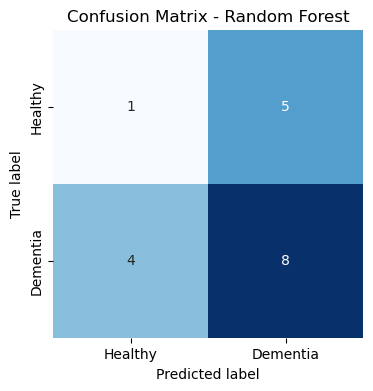

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm_rf = confusion_matrix(y_test_peak, predictions_rf)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Healthy", "Dementia"], yticklabels=["Healthy", "Dementia"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

The Random Forest Classifier did not out perform Decision Trees Classifier. This may be due to limited sample size.

## Table Results

In [36]:
# Define the model names, accuracy scores, precision scores, and recall scores
model_names = ["Decision Tree", "Logistic Regression", "K-Nearest Neighbors", "SVM", "Random Forest"]
accuracy_scores = [accuracy_majority_vote, accuracy_majority_vote_logistic, accuracy_majority_vote_knn, accuracy_majority_vote_svm, accuracy_majority_vote_rf]
precision_scores = [precision_dtc, precision_lgr, precision_knn, precision_svm, precision_rf]
recall_scores = [recall_dtc, recall_lgr, recall_knn, recall_svm, recall_rf]

# Create a list of lists with the data
table_data = [[model_names[i], accuracy_scores[i], precision_scores[i], recall_scores[i]] for i in range(len(model_names))]

# Define the table headers
headers = ["Model", "Accuracy", "Precision", "Recall"]

# Print the table using tabulate
print(tabulate(table_data, headers, tablefmt="fancy_grid"))


╒═════════════════════╤════════════╤═════════════╤══════════╕
│ Model               │   Accuracy │   Precision │   Recall │
╞═════════════════════╪════════════╪═════════════╪══════════╡
│ Decision Tree       │   0.833333 │    0.846154 │ 0.916667 │
├─────────────────────┼────────────┼─────────────┼──────────┤
│ Logistic Regression │   0.555556 │    0.625    │ 0.833333 │
├─────────────────────┼────────────┼─────────────┼──────────┤
│ K-Nearest Neighbors │   0.722222 │    0.769231 │ 0.833333 │
├─────────────────────┼────────────┼─────────────┼──────────┤
│ SVM                 │   0.555556 │    0.625    │ 0.833333 │
├─────────────────────┼────────────┼─────────────┼──────────┤
│ Random Forest       │   0.5      │    0.615385 │ 0.666667 │
╘═════════════════════╧════════════╧═════════════╧══════════╛


After observing the performance metrics from the table, it is evident that Decision Tree Classifier obtained highest accuracy, precision and recall.

# Convolutional Neural Network (CNN)

After completing the exploration of classical machine learning models, I have come to the realization that interpretability is not a crucial factor in determining the importance of EEG components. Therefore, I am now venturing into the realm of convolutional neural networks (CNNs) to evaluate whether they can provide improved accuracy. CNNs have proven to be effective in capturing complex patterns and spatial relationships in data, making them well-suited for analyzing EEG signals. By leveraging the power of deep learning, I hope to uncover hidden insights and achieve enhanced accuracy in my EEG classification task.

I will create my own neural network and not use existing pre-trained models like DeepConvNet as these models take raw EEG data as input, while I am specifically analyzing the ICA componenets of EEG data.

In [181]:
df_peak_full.columns

Index(['Type', 'C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'Fz',
       'O1', 'O2', 'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'Age', 'Group',
       'MMSE', 'dx_num'],
      dtype='object')

In [37]:
df_peak_full = df_peak_full.drop(['Type', 'Age', 'Group','dx_num'], axis=1).add_prefix("peak_")
df_mean_full = df_mean_full.drop(['Type', 'Age', 'Group','MMSE','dx_num'], axis=1).add_prefix("mean_")
df_gp_full = df_gp_full.drop(['Type', 'Age', 'MMSE','Group'], axis=1).add_prefix("gp_")

# Concatenate the dataframes horizontally
df_combined = pd.concat([df_peak_full, df_mean_full, df_gp_full], axis=1)


In [38]:
df_combined.head()


,peak_C3,peak_C4,peak_Cz,peak_F3,peak_F4,peak_F7,peak_F8,peak_Fp1,peak_Fp2,peak_Fz,...,gp_O1,gp_O2,gp_P3,gp_P4,gp_Pz,gp_T3,gp_T4,gp_T5,gp_T6,gp_dx_num
subj_id,,,,,,,,,,,,,,,,,,,,,
sub-001,0.406802,0.406802,0.406802,0.406802,0.406802,0.406802,0.406802,0.360120,0.406802,0.406802,...,0.000305,0.000312,0.000297,0.000300,0.000299,0.000297,0.000299,0.000308,0.000302,1
sub-002,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,0.465263,...,0.000410,0.000405,0.000395,0.000390,0.000392,0.000401,0.000395,0.000407,0.000409,1
sub-003,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,0.336491,...,0.000133,0.000135,0.000125,0.000126,0.000122,0.000124,0.000124,0.000136,0.000142,1
sub-004,0.413539,0.495680,0.413539,0.495680,0.495680,0.495680,0.495680,0.413539,0.495680,0.495680,...,0.000429,0.000419,0.000382,0.000388,0.000379,0.000400,0.000394,0.000386,0.000390,1
sub-005,0.419102,0.419102,0.419102,0.419102,0.395473,0.419102,0.419102,0.400448,0.419102,0.419102,...,0.000467,0.000434,0.000443,0.000427,0.000421,0.000438,0.000428,0.000444,0.000427,1


### Preparing data for CNN

In [39]:
X = df_combined.drop('gp_dx_num', axis = 1)
y = df_combined['gp_dx_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32, stratify = y)


In [281]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data for CNN
input_shape = (X_train_scaled.shape[1], 1)
X_train_reshaped = X_train_scaled.reshape((-1,) + input_shape)
X_test_reshaped = X_test_scaled.reshape((-1,) + input_shape)

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, batch_size=4, epochs=10, validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print("Test Accuracy - CNN:", accuracy)


Epoch 1/10
18/18 [==============================] - 1s 10ms/step - loss: 0.6916 - accuracy: 0.6429 - val_loss: 0.6577 - val_accuracy: 0.6667
Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6714 - val_loss: 0.9029 - val_accuracy: 0.6667
Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6714 - val_loss: 1.5008 - val_accuracy: 0.6667
Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6714 - val_loss: 0.9757 - val_accuracy: 0.6667
Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 0.5570 - accuracy: 0.6714 - val_loss: 0.5652 - val_accuracy: 0.6667
Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 0.4768 - accuracy: 0.8000 - val_loss: 1.5037 - val_accuracy: 0.7222
Epoch 7/10
18/18 [==============================] - 0s 3ms/step - loss: 0.5386 - accuracy: 0.7429 - val_loss: 1.6428 - val_accuracy: 0.7778
Epoch 8/10
18/18 [=

### Plot Summary

In [266]:
model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_234 (Conv1D)         (None, 56, 32)            128       
                                                                 
 max_pooling1d_230 (MaxPooli  (None, 28, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_235 (Conv1D)         (None, 26, 64)            6208      
                                                                 
 max_pooling1d_231 (MaxPooli  (None, 13, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_236 (Conv1D)         (None, 11, 128)           24704     
                                                                 
 max_pooling1d_232 (MaxPooli  (None, 5, 128)         

In the provided model summary, we can observe a sequential architecture consisting of convolutional layers followed by max pooling layers. The model utilizes multiple convolutional layers with increasing numbers of filters to extract hierarchical features from the input data. The final layers consist of a flatten operation followed by dense layers, leading to a binary classification output (healthy vs dementia) with 2 neurons.

### Plotting Training and Validation Curves

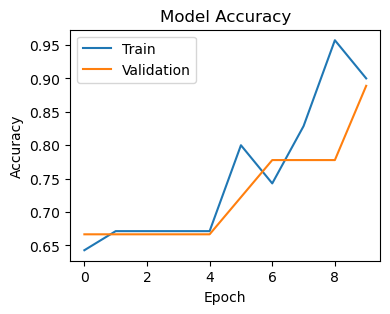

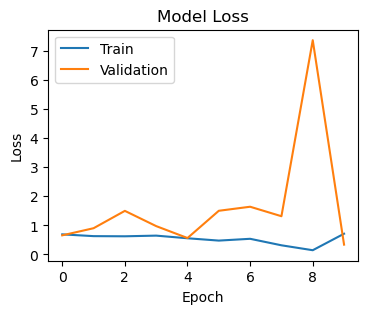

In [306]:
plt.figure(figsize=(4, 3))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(4, 3))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


The accuracy graph shows an upward trend in accuracy from the 4th epoch onwards, indicating that the model's performance improves over time. It reaches a high accuracy of 89% on the 10th epoch, suggesting that the model has learned to make accurate predictions.

Regarding the loss graph, it demonstrates that the model's loss remains consistently low throughout the training process. However, there is a slight increase in loss at the 8th epoch, indicating a temporary deviation. Fortunately, by the 10th epoch, the loss decreases again, implying that the model has managed to recover and maintain its performance.

# Results

## Results from ML models

The Decision Tree classifier outperforms the other models in terms of accuracy, precision score, and recall score. The Decision Tree model achieved the highest accuracy, indicating its overall correctness in predicting the disease status. Furthermore, it obtained the highest precision score, demonstrating its ability to correctly classify individuals with dementia. Additionally, the model exhibited the highest recall score, indicating its capability to identify a larger proportion of true positive cases. Based on these observations, the Decision Tree classifier emerges as the clear winner among the models considered in the analysis.

The limited number of training samples in EEG data for dementia diagnosis may be a potential reason why random forest models may not outperform decision trees. Random forests typically benefit from a larger amount of training data to effectively capture complex patterns and improve generalization. 


## Results from Convoluted Neural Networks

Despite the longer computational time required, the CNN neural network exhibited exceptional accuracy in diagnosing  Dementia and Healthy Aging. The utilization of deep learning techniques enabled the network to effectively extract intricate spatial and temporal features from the EEG data, leading to improved diagnostic accuracy compared to classical ML models.

## Overarching Non-Technical Results

In summary, through the examination of the peak frequency, mean frequency, amd Global Powers of EEG components in subjects, we have achieved relatively accurate diagnoses of Dementia and Healthy Aging. Our results demonstrate the effectiveness of employing both classical ML models, particularly decision trees, as well as advanced techniques like CNNs to analyze EEG data and accurately classify neurological conditions. These findings hold promise for enhancing the diagnosis and understanding of these disorders, ultimately contributing to improved patient care and treatment strategies.

# Next Steps


Investigation of feature importance: The identification of important features in the random forest model provides valuable insights into the underlying characteristics of neurological conditions. Researchers can delve deeper into these features to understand their physiological or neurological significance, potentially leading to the discovery of new biomarkers or informative features for diagnosis.

Validation on larger and diverse datasets: While the current results show promise, validating the models on larger and more diverse datasets is crucial. ML scientists should seek opportunities to access and analyze larger cohorts of EEG data to ensure the generalizability and robustness of their models. This can involve collaborations with research institutions, medical centers, or data sharing initiatives.

Translation to clinical practice: To make a real impact, ML scientists should work closely with clinicians, neurologists, and healthcare professionals to validate the models in clinical settings. The field can benefit from collaborative efforts to integrate ML algorithms into existing diagnostic workflows and evaluate their performance in real-world scenarios. This will help in assessing the feasibility, reliability, and practical utility of the developed models.